<a href="https://colab.research.google.com/github/Nobu90/scaling-broccoli/blob/main/sentence_piece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 루브릭 

|평가 문항|상세 기준|
|:---|:---|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?| 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

# 환경 세팅

In [ ]:
! pip install sentencepiece
! pip install matplotlib
!sudo apt-get install g++ openjdk-7-jdk python-dev python3-dev   
!pip3 install JPype1-py3
!pip3 install konlpy   
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np

import konlpy
from konlpy.tag import Mecab

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.initializers import Constant

import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

from collections import Counter

import sentencepiece as spm
import time
import os

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

print(tf.__version__)
print(np.__version__)
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)
!python --version

# Mecab - Morphs

## 데이터 로드

In [525]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')

## 결측치 및 중복값 제거

In [526]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

## 문장 길이 분석

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


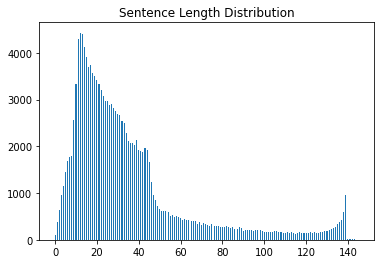

In [527]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=0.5)
plt.title("Sentence Length Distribution")
plt.show()

In [528]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in train_data['document']:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data['document'], 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [529]:
check_sentence_with_length(train_data['document'], 146)

"스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...독일3사&슈퍼카 홍보 프로그램도 아니구.대중적인 자동차 방송으로 이루어 졌으면 합니다. 보는내내 ""카탈로그 책자""를 ""동영상으로 보여주는 방송"" 같아서 씁쓸하네요.!"
"""니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 홍보하면 안되지! 초반 45분은 멋지게 열더니.. 억지 반전, 하드고어로 시간끌다가, 허둥지둥 화해로 끝내버리네. 90분 러닝타임에 엔딩자막만 11분 틀어주는 해괴망측한 영화~!"
"2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 둘째~"" 재문: ""아줌마! 미안해~ 그냥.. 아줌마! 나 그 남방 잘 어울려ㅠ_ㅠ?"" 대식에게 복수하려던 1주일 전_ 대식의 엄마를 먼저 만났다. 사랑의 꽃남방도..^-^o"


## 문장 길이 조절

In [530]:
max_len = 60
min_len = 5

train_data = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len)]
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len)]

test_data = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len)]
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len)]

print(train_data.shape)
print(test_data.shape)

(123040, 3)
(41198, 3)


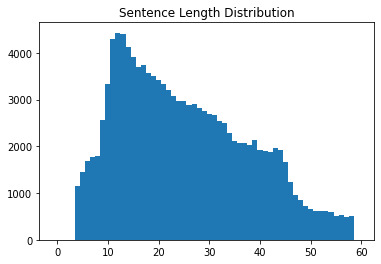

In [531]:
sentence_length = np.zeros((max_len), dtype=int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [532]:
print(train_data.shape)
print(test_data.shape)

(123040, 3)
(41198, 3)


## 불용어 제거 및 토큰화

In [533]:
start = time.time()

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=50000):
  
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(50000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

end = time.time()
print(end - start)

32.08212494850159


In [534]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[4])
print(index_to_word[5])
print(word_to_index['영화'])

.
영화
5


In [535]:
print(len(index_to_word))

42710


In [536]:
word_to_index = {k:(v) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])    
print(word_to_index['the']) 
print(index_to_word[3]) 
print(index_to_word[4])    
print(index_to_word[5])
print(word_to_index['영화'])

<BOS>
1906
<UNUSED>
.
영화
5


In [537]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 패딩 추가

In [538]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=60)

test_data = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=60)

print(train_data.shape)
print(test_data.shape)

(123040, 60)
(41198, 60)


## 데이터 분리

In [539]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

## 임베딩 사이즈 및 차원 설정

In [540]:
vocab_size = 50000
word_vector_dim = 100

## Mecab_morphs_lstm 모델

In [541]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(256))   
lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, None, 100)         5000000   
                                                                 
 lstm_18 (LSTM)              (None, 256)               365568    
                                                                 
 dense_36 (Dense)            (None, 8)                 2056      
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


## 컴파일 및 학습

In [542]:
start = time.time()

lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

lstm_history = lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

end = time.time()
print(end - start)

Epoch 1/5
193/193 [==============================] - 27s 120ms/step - loss: 0.4602 - accuracy: 0.7852 - val_loss: 0.3622 - val_accuracy: 0.8411
Epoch 2/5
193/193 [==============================] - 11s 59ms/step - loss: 0.3098 - accuracy: 0.8727 - val_loss: 0.3587 - val_accuracy: 0.8453
Epoch 3/5
193/193 [==============================] - 8s 42ms/step - loss: 0.2589 - accuracy: 0.8981 - val_loss: 0.3705 - val_accuracy: 0.8431
Epoch 4/5
193/193 [==============================] - 8s 42ms/step - loss: 0.2203 - accuracy: 0.9142 - val_loss: 0.3730 - val_accuracy: 0.8436
Epoch 5/5
193/193 [==============================] - 7s 36ms/step - loss: 0.1862 - accuracy: 0.9284 - val_loss: 0.4047 - val_accuracy: 0.8430
84.63340830802917


## 결과 데이터

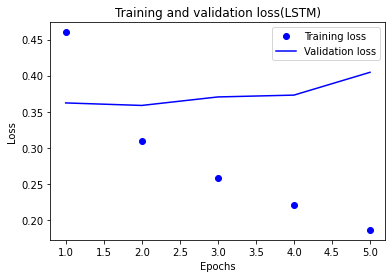

In [543]:
lstm_history_dict = lstm_history.history

acc = lstm_history_dict['accuracy']
val_acc = lstm_history_dict['val_accuracy']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

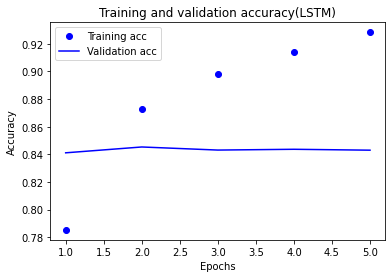

In [544]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [545]:
lstm_results = lstm_model.evaluate(test_data,  y_test, verbose=2)

print(lstm_results)

1288/1288 - 5s - loss: 0.4109 - accuracy: 0.8420 - 5s/epoch - 4ms/step
[0.4108560383319855, 0.8420311808586121]


# Sentencepiece - Unigram

## 데이터 로드

In [546]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')


## 결측치 및 중복값 제거

In [547]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

## 문장 길이 조절

In [548]:
max_len = 60
min_len = 5

train_corpus = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'document']
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'label']

test_corpus = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'document']
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'label']

print(len(train_corpus))
print(len(test_corpus))

123040
41198


## Unigram 옵션 학습

In [549]:
start = time.time()

temp_file = '/content/drive/MyDrive/deepNLP/Sentencepiece_uigram'

with open(temp_file, 'w') as f:
    for row in train_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=unigram_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

end = time.time()
print(end - start)

17.54297423362732


## Unigram 토큰화

In [550]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("/content/unigram_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [551]:
s = spm.SentencePieceProcessor()
s.Load('/content/unigram_spm.model')

train_data, word_index, index_word = sp_tokenize(s, train_corpus)
test_data, word_index, index_word = sp_tokenize(s, test_corpus)

print(train_data.shape)
print(test_data.shape)

(123040, 60)
(41198, 60)


## 데이터 분리

In [552]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

## SP_unigram_lstm 모델

In [553]:
ugm_lstm_model = tf.keras.Sequential()
ugm_lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
ugm_lstm_model.add(tf.keras.layers.LSTM(256))   
ugm_lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
ugm_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

ugm_lstm_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 100)         5000000   
                                                                 
 lstm_19 (LSTM)              (None, 256)               365568    
                                                                 
 dense_38 (Dense)            (None, 8)                 2056      
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


## 컴파일 및 학습

In [554]:
start = time.time()

ugm_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

ugm_lstm_history = ugm_lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

end = time.time()
print(end - start)

Epoch 1/5
193/193 [==============================] - 25s 115ms/step - loss: 0.4763 - accuracy: 0.7757 - val_loss: 0.3696 - val_accuracy: 0.8405
Epoch 2/5
193/193 [==============================] - 13s 67ms/step - loss: 0.2660 - accuracy: 0.8939 - val_loss: 0.3691 - val_accuracy: 0.8435
Epoch 3/5
193/193 [==============================] - 11s 56ms/step - loss: 0.1929 - accuracy: 0.9279 - val_loss: 0.4027 - val_accuracy: 0.8375
Epoch 4/5
193/193 [==============================] - 9s 46ms/step - loss: 0.1392 - accuracy: 0.9509 - val_loss: 0.4540 - val_accuracy: 0.8327
Epoch 5/5
193/193 [==============================] - 8s 44ms/step - loss: 0.0996 - accuracy: 0.9663 - val_loss: 0.5840 - val_accuracy: 0.8244
66.76785683631897


## 결과 데이터

In [555]:
ugm_lstm_history_dict = ugm_lstm_history.history

acc = ugm_lstm_history_dict['accuracy']
val_acc = ugm_lstm_history_dict['val_accuracy']
loss = ugm_lstm_history_dict['loss']
val_loss = ugm_lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

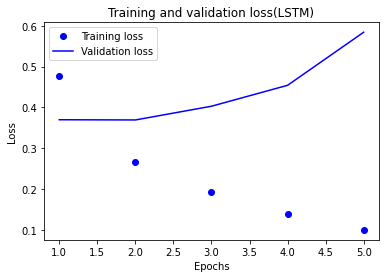

In [556]:
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

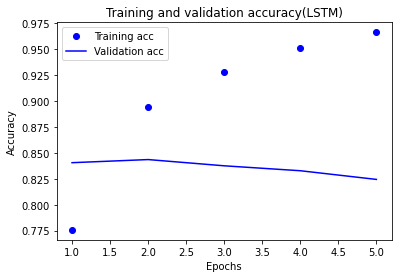

In [557]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [558]:
ugm_lstm_results = ugm_lstm_model.evaluate(test_data,  y_test, verbose=2)

1288/1288 - 5s - loss: 0.5987 - accuracy: 0.8198 - 5s/epoch - 4ms/step


# Sentencepiece - BPE

## 데이터 로드

In [559]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')

## 결측치 및 중복값 제거

In [560]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

## 문장 길이 조절

In [561]:
max_len = 60
min_len = 5

train_corpus = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'document']
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'label']

test_corpus = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'document']
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'label']

print(len(train_corpus))
print(len(test_corpus))

123040
41198


## BPE 옵션 학습

In [562]:
start = time.time()

temp_file = '/content/drive/MyDrive/deepNLP/Sentencepiece_bpe'

with open(temp_file, 'w') as f:
    for row in train_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=bpe_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)

end = time.time()
print(end - start)

99.36567306518555


## BPE 토큰화

In [563]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./bpe_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [564]:
s = spm.SentencePieceProcessor()
s.Load('/content/bpe_spm.model')

train_data, word_index, index_word = sp_tokenize(s, train_corpus)
test_data, word_index, index_word = sp_tokenize(s, test_corpus)

print(train_data.shape)
print(test_data.shape)

(123040, 60)
(41198, 60)


## 데이터 분리

In [565]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

## SP_BPE_lstm 모델

In [566]:
bpm_lstm_model = tf.keras.Sequential()
bpm_lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
bpm_lstm_model.add(tf.keras.layers.LSTM(256))   
bpm_lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
bpm_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

bpm_lstm_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 100)         5000000   
                                                                 
 lstm_20 (LSTM)              (None, 256)               365568    
                                                                 
 dense_40 (Dense)            (None, 8)                 2056      
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


## 컴파일 및 학습

In [567]:
start = time.time()
bpm_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

bpm_lstm_history = bpm_lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

end = time.time()

print(end - start)

Epoch 1/5
193/193 [==============================] - 33s 157ms/step - loss: 0.4526 - accuracy: 0.7878 - val_loss: 0.3569 - val_accuracy: 0.8440
Epoch 2/5
193/193 [==============================] - 14s 75ms/step - loss: 0.2533 - accuracy: 0.8992 - val_loss: 0.3641 - val_accuracy: 0.8409
Epoch 3/5
193/193 [==============================] - 13s 66ms/step - loss: 0.2104 - accuracy: 0.9201 - val_loss: 0.4179 - val_accuracy: 0.8382
Epoch 4/5
193/193 [==============================] - 11s 58ms/step - loss: 0.1487 - accuracy: 0.9457 - val_loss: 0.4502 - val_accuracy: 0.8309
Epoch 5/5
193/193 [==============================] - 8s 41ms/step - loss: 0.1091 - accuracy: 0.9601 - val_loss: 0.5815 - val_accuracy: 0.8285
78.94586038589478


## 결과 데이터

In [568]:
bpm_lstm_history_dict = bpm_lstm_history.history

acc = bpm_lstm_history_dict['accuracy']
val_acc = bpm_lstm_history_dict['val_accuracy']
loss = bpm_lstm_history_dict['loss']
val_loss = bpm_lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

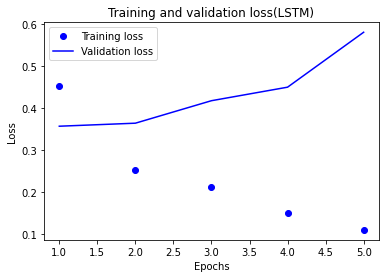

In [569]:
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

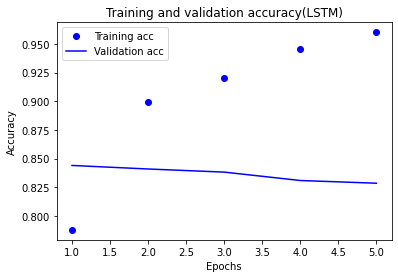

In [570]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [571]:
bpm_lstm_results = bpm_lstm_model.evaluate(test_data,  y_test, verbose=2)

1288/1288 - 6s - loss: 0.5911 - accuracy: 0.8262 - 6s/epoch - 5ms/step


# Sentencepiece - Char

## 데이터 로드

In [585]:
train_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Exploration/e08/data/ratings_test.txt')

## 결측치 및 중복값 제거

In [586]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

## 문장 길이 조절

In [587]:
max_len = 60
min_len = 5

train_corpus = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'document']
y_train = train_data.loc[(train_data['document'].str.len() >= min_len) & (train_data['document'].str.len() < max_len), 'label']

test_corpus = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'document']
y_test = test_data.loc[(test_data['document'].str.len() >= min_len) & (test_data['document'].str.len() < max_len), 'label']

print(len(train_corpus))
print(len(test_corpus))

123040
41198


## Char 옵션 학습

In [588]:
start = time.time()

temp_file = '/content/drive/MyDrive/deepNLP/Sentencepiece_char'

with open(temp_file, 'w') as f:
    for row in train_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=char_spm --vocab_size={} --model_type=char'.format(temp_file, vocab_size)    
)

end = time.time()
print(end - start)

0.7919669151306152


## Char 토큰화

In [589]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./char_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [590]:
s = spm.SentencePieceProcessor()
s.Load('/content/char_spm.model')

train_data, word_index, index_word = sp_tokenize(s, train_corpus)
test_data, word_index, index_word = sp_tokenize(s, test_corpus)

print(train_data.shape)
print(test_data.shape)

(123040, 60)
(41198, 60)


## 데이터 분리

In [591]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train, test_size=0.2, shuffle=True, random_state=34)

## SP_Char_lstm 모델

In [592]:
char_lstm_model = tf.keras.Sequential()
char_lstm_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
char_lstm_model.add(tf.keras.layers.LSTM(256))   
char_lstm_model.add(tf.keras.layers.Dense(8, activation='relu'))
char_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

char_lstm_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 100)         5000000   
                                                                 
 lstm_22 (LSTM)              (None, 256)               365568    
                                                                 
 dense_44 (Dense)            (None, 8)                 2056      
                                                                 
 dense_45 (Dense)            (None, 1)                 9         
                                                                 
Total params: 5,367,633
Trainable params: 5,367,633
Non-trainable params: 0
_________________________________________________________________


## 컴파일 및 학습

In [593]:
start = time.time()
char_lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

char_lstm_history = char_lstm_model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

end = time.time()
print(end - start)

Epoch 1/5
193/193 [==============================] - 18s 78ms/step - loss: 0.5033 - accuracy: 0.7526 - val_loss: 0.4466 - val_accuracy: 0.7919
Epoch 2/5
193/193 [==============================] - 8s 42ms/step - loss: 0.4298 - accuracy: 0.7996 - val_loss: 0.4217 - val_accuracy: 0.8027
Epoch 3/5
193/193 [==============================] - 8s 39ms/step - loss: 0.3982 - accuracy: 0.8163 - val_loss: 0.3996 - val_accuracy: 0.8154
Epoch 4/5
193/193 [==============================] - 8s 39ms/step - loss: 0.3767 - accuracy: 0.8285 - val_loss: 0.3882 - val_accuracy: 0.8218
Epoch 5/5
193/193 [==============================] - 7s 36ms/step - loss: 0.3618 - accuracy: 0.8370 - val_loss: 0.3868 - val_accuracy: 0.8230
48.565237522125244


## 결과 데이터

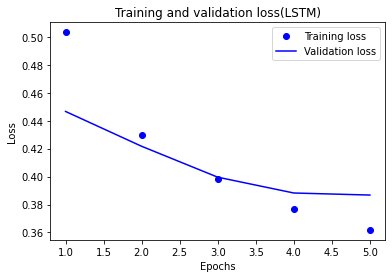

In [594]:
char_lstm_history_dict = char_lstm_history.history

acc = char_lstm_history_dict['accuracy']
val_acc = char_lstm_history_dict['val_accuracy']
loss = char_lstm_history_dict['loss']
val_loss = char_lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

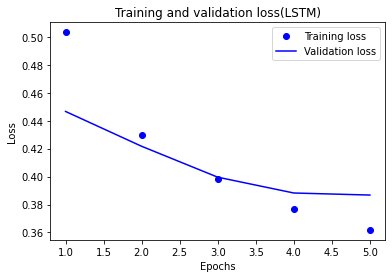

In [595]:
plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

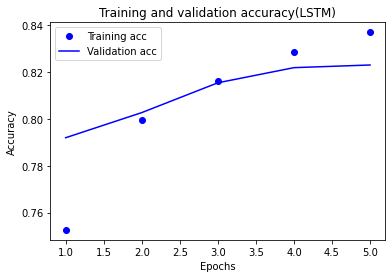

In [596]:
plt.clf()   

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy(LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [597]:
char_lstm_results = char_lstm_model.evaluate(test_data,  y_test, verbose=2)

1288/1288 - 5s - loss: 0.3871 - accuracy: 0.8266 - 5s/epoch - 4ms/step


# 최종 결과 정리

|토큰화 방법|정확도|학습 시간|훈련 시간|에폭 수|
|:---|:---|:---|:---|:---|
|Mecab-Morphs| 0.8420|32.08초|84.63초|5|
|SentencePiece-Unigram|0.8198|17.54초|66.76초|5|
|SentencePiece-BPE|0.8262|99.36초|78.94초|5|
|SentencePiece-Char|0.8266|0.79초|48.56초|5|
|SentencePiece-Char|0.8391|1.28초|99.85초|12|

## 특징 

1. 정확도는 Mecab의 형태소 분석이 가장 뛰어나지만 훈련 시간은 가장 길다(동일 에폭 수 기준) 
2. char 옵션의 경우 오버피팅이 잘 일어나지 않아 에폭 수를 늘릴 경우 Mecab-morphs와 비슷한 수준으로 정확도가 상승한다.
3. 학습에 걸리는 시간은 BPE 옵션이 유독 느리고, char 옵션이 압도적으로 빠르다.
4. 한국어 처리에서는 센텐스피스에서 char 옵션이 속도 및 정확도 모두 가장 좋았다.

## 결론

정확도가 중요하다면 Mecab을 속도가 중요하다면 SentencePiece-Char (동일 에폭 수) 옵션을, 중간을 원한다면 SentencePiece-Char의 에폭 수를 조금 늘려 사용한다.

